# Classical methods in order to detect schizophrenia with EEG dataset

## Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from mne.filter import construct_iir_filter
from mne.preprocessing import ICA
from mne.io import RawArray, read_raw_edf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from tools.eegPowerBand import eeg_power_band
from tools.MNEtoXYSets import transform

from statsmodels.tsa.ar_model import AutoReg

## Loading EEG raw data

In [2]:
def load_edf():
    edfs_path = "..\dataverse_files"
    manifest_path = "..\dataverse_files\MANIFEST.txt"

    raw_patients_data = []
    edfs_file_names = [f for f in os.listdir(edfs_path) if f.endswith('.edf')]

    for file_name in edfs_file_names:
        path = edfs_path + '\\' + file_name 
        raw_data = mne.io.read_raw_edf(path, preload=True, verbose=False)
        raw_patients_data.append(raw_data)

    return raw_patients_data

## Preprocessing

#### Preprocessing with filtering (Butterworth lowpass filter 6th order with fcut=50Hz)

In [3]:
def preprocessing_by_filtering(order = 6, f_pass = 50, f_stop = None, filter_type = 'low'):
    raw_patients_data = load_edf()
    iir_filter = construct_iir_filter(dict(order=order, ftype='butter', output='sos'), f_pass, f_stop, 250, filter_type, verbose=False)

    return [ raw_patient_data
                .filter(l_freq=None, h_freq=None, picks='eeg', method='iir', iir_params=iir_filter, n_jobs=-1, verbose=False) 
            for raw_patient_data in raw_patients_data ]

#### Preprocessing with ICA

##### FASTICA From MNE

In [4]:
def preprocessing_by_MNE_ICA(n_components = 0, method = 'fastica'):
    fitted_patients_data = []
    ica_patients_data = []
    raw_patients_data = load_edf()
    # Optimalization for ICA
    ica_raw_patients_data = [raw_patient_data.copy().filter(l_freq=1., h_freq=None, verbose = False) for raw_patient_data in raw_patients_data]

    for ica_raw_patient_data in ica_raw_patients_data:
        ica = ICA(n_components, method, verbose = False)
        tmp = ica.fit(ica_raw_patient_data, verbose = False)
        fitted_patients_data.append(tmp.get_sources(ica_raw_patient_data))

    for index, ica_feature in enumerate(fitted_patients_data):
        ica_patients_data.append(RawArray(ica_feature.get_data(), raw_patients_data[index].info, verbose=False))

    return ica_patients_data

##### FASTICA from sklearn

In [5]:
def preprocessing_by_sklearn_ICA(fun = 'logcosh'):    
    fastICA = FastICA(fun, whiten='unit-variance')
    raw_patients_data = load_edf()
    fastICAfeatures = [raw_patient_data.copy().get_data() for raw_patient_data in raw_patients_data]
    fastica_patients_data = []

    for index, patient in enumerate(raw_patients_data):
        fastICA.fit(patient.get_data()[:-1].reshape(-1, 1))
        fastICAfeatures[index][-1] = fastICA.transform(patient.get_data()[-1].reshape(-1, 1)).reshape(1, -1)

    for index, fastICAfeature in enumerate(fastICAfeatures):
        fastica_patients_data.append(RawArray(fastICAfeature, raw_patients_data[index].info, verbose=False))
        
    return fastica_patients_data

### Preprocessing

In [46]:
def preprocessing(method, args):
    ret_value = None
    if method == 'filter':
        ret_value = preprocessing_by_filtering(**args)
    elif method == 'mne_ica':
        ret_value = preprocessing_by_MNE_ICA(**args)
    elif method == 'mne_sklearn':
        ret_value = preprocessing_by_sklearn_ICA(**args)
    else:
        print('Wrong method')

    return ret_value

## Extraction

#### Energy band

`eeg_power_band(data)` is available in `tools/eegPowerBand.py` file

#### Variance

In [9]:
def variance_extraction(data):
    featuresVar = []
    for index, feature in enumerate(data.get_data()):
        featuresVar.append(np.var(feature, axis = 1))

    return np.array(featuresVar)

#### Autoregression

In [10]:
def autoregresion_extraction(data):
    featuresVar = []
    for patient in data:
        patient_arr = []
        for electrode in patient:
            model = AutoReg(electrode, lags=10)
            result = model.fit()
            patient_arr.append(result.params.flatten())
        featuresVar.append(patient_arr)

    for index, el in enumerate(featuresVar):
        featuresVar[index] = np.array(el).flatten()

    return np.array(featuresVar)

#### L1 Norm

In [11]:
def l1norm_extraction(data):
    featuresVar = []
    for index, feature in enumerate(data.get_data()):
        featuresVar.append(np.linalg.norm(feature, ord = 1, axis = 1))

    return np.array(featuresVar)

### Extraction

In [63]:
def extraction(method, data):
    ret_value = None
    if method == 'power_band':
        ret_value = eeg_power_band(data)
    elif method == 'variance':
        ret_value = variance_extraction(data)
    elif method == 'autoregresion':
        ret_value = autoregresion_extraction(data)
    elif method == 'l1norm':
        ret_value = l1norm_extraction(data)
    else:
        print('Wrong method')

    return ret_value

## Selection

#### _t-test Welch (rank method)_

In [13]:
def t_stats_selection(X, y, features=10):
    tstat = np.abs(stats.ttest_ind(X, y, equal_var = False).statistic)
    ind = np.argpartition(tstat, -features)[-features:]

    return X[:,ind]

#### _PCA_

In [14]:
def pca_selection(X, y, n_components = 5):
    pca = PCA(n_components)
    return pca.fit_transform(X, y)

#### _SFS_

In [15]:
def sfs_selection(X, y, n_features = 5):
    lda = LinearDiscriminantAnalysis(solver='lsqr')
    sfs = SequentialFeatureSelector(lda, n_features_to_select = n_features)
    return sfs.fit_transform(X, y)

#### Selection

In [62]:
def selection(method, X, y, args):
    ret_value = None
    if method == 't_stats':
        ret_value = t_stats_selection(X, y, **args)
    elif method == 'pca':
        ret_value = pca_selection(X, y, **args)
    elif method == 'autoregresion':
        ret_value = sfs_selection(X, y, **args)
    else:
        print('Wrong method')

    return ret_value

## Dataset split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(t_stats_selection(eeg_power_band(X3), y, 18), y, test_size=0.2, shuffle=True)

Effective window size : 1.024 (s)


## Classification

In [123]:
def classification(estimator, X_train, X_test, y_train, y_test, log = True, to_file = False, **args):
    clr = estimator(**args)
    clr.fit(X_train, y_train)
    y_pred = clr.predict(X_test)
    res_f1_score = f1_score(y_test, y_pred)
    res_acc = clr.score(X_test, y_test)

    if log:
        print(f"{estimator().__class__.__name__} - Params: {args}")
        print(f"F1 Score: {res_f1_score}")
        print(f"ACC: {res_acc}")

    if to_file:
        from datetime import datetime

        ts_name = f'images/experiment-{estimator().__class__.__name__}-{datetime.timestamp(datetime.now())}'
        os.makedirs(f'{ts_name}')
        with open(f'{ts_name}/params', 'w') as file:
            file.write(f'Estimator: {estimator().__class__.__name__}\n')
            file.write(f'Params: {args}\n')
            file.write(f'acc: {res_acc}, f1_score: {res_f1_score}')

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    if to_file:
        plt.savefig(f'{ts_name}/{estimator().__class__.__name__}-confussion-matrix.png', facecolor='white', transparent=False)
    RocCurveDisplay.from_predictions(y_test, y_pred)
    if to_file:
        plt.savefig(f'{ts_name}/{estimator().__class__.__name__}-roc-curve.png', facecolor='white', transparent=False)

    return (res_acc, res_f1_score)

#### KNN

KNeighborsClassifier - Params: {}
F1 Score: 0.9019607843137255
ACC: 0.8908296943231441


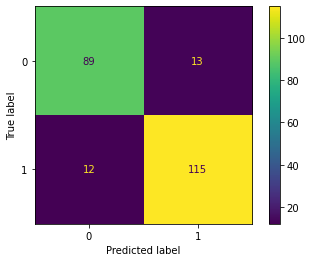

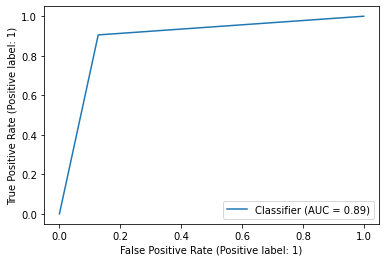

In [20]:
classification(KNeighborsClassifier, X_train, X_test, y_train, y_test)

#### LDA & QDA

LinearDiscriminantAnalysis - Params: {'solver': 'lsqr'}
F1 Score: 0.7680608365019013
ACC: 0.7336244541484717


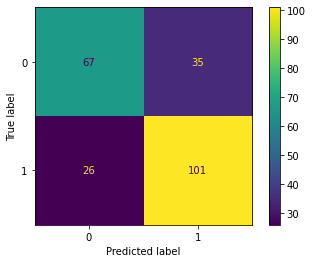

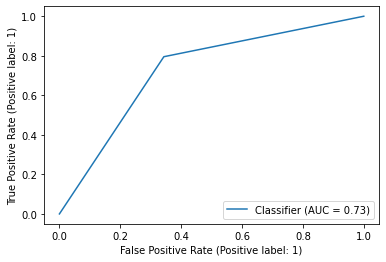

In [21]:
classification(LinearDiscriminantAnalysis, X_train, X_test, y_train, y_test, solver='lsqr')

QuadraticDiscriminantAnalysis - Params: {}
F1 Score: 0.8137931034482759
ACC: 0.7641921397379913


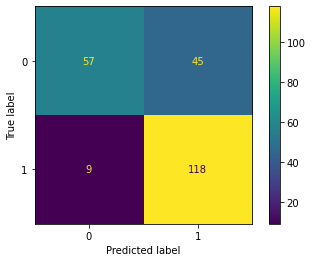

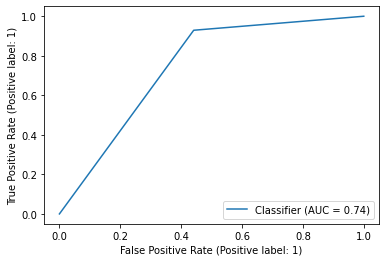

In [22]:
classification(QuadraticDiscriminantAnalysis, X_train, X_test, y_train, y_test)

#### SVC

SVC - Params: {'kernel': 'linear'}
F1 Score: 0.7134831460674157
ACC: 0.5545851528384279
SVC - Params: {'kernel': 'poly'}
F1 Score: 0.8436363636363636
ACC: 0.8122270742358079
SVC - Params: {'kernel': 'rbf'}
F1 Score: 0.8409090909090909
ACC: 0.8165938864628821
SVC - Params: {'kernel': 'sigmoid'}
F1 Score: 0.5654008438818565
ACC: 0.5502183406113537


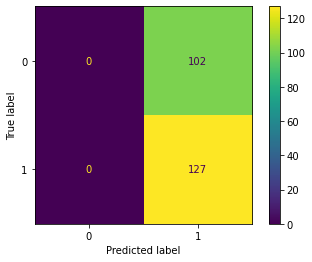

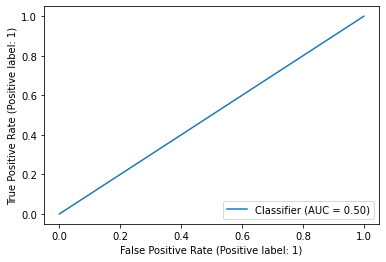

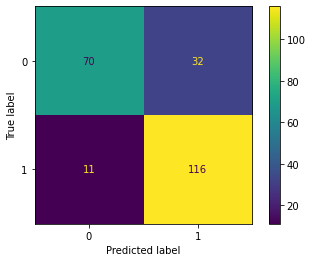

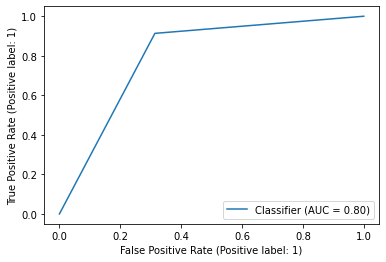

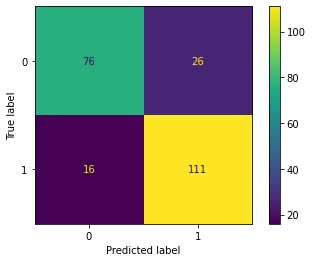

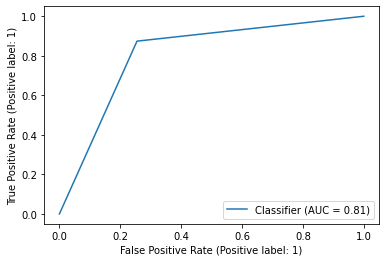

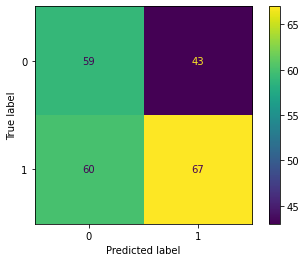

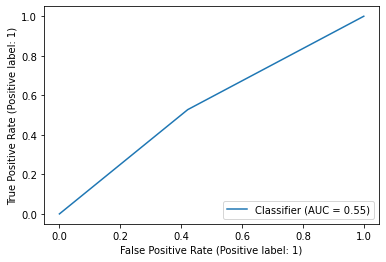

In [23]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    classification(SVC, X_train, X_test, y_train, y_test, kernel=kernel)

#### DecisionTreeClassifier

DecisionTreeClassifier - Params: {}
F1 Score: 0.751054852320675
ACC: 0.74235807860262


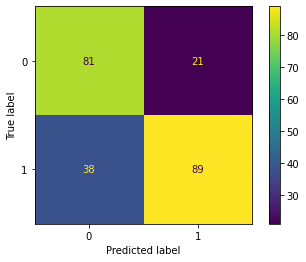

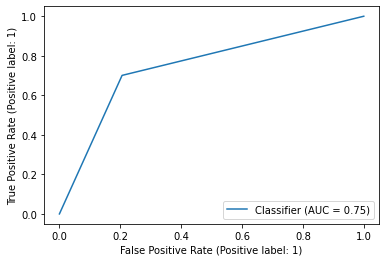

In [24]:
classification(DecisionTreeClassifier, X_train, X_test, y_train, y_test)


#### LogisticRegression

LogisticRegression - Params: {}
F1 Score: 0.7134831460674157
ACC: 0.5545851528384279


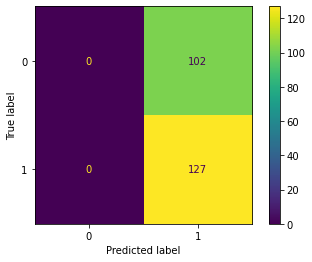

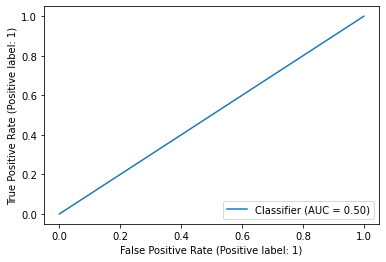

In [25]:
classification(LogisticRegression, X_train, X_test, y_train, y_test)

#### NaiveBayes

GaussianNB - Params: {}
F1 Score: 0.5544554455445545
ACC: 0.6069868995633187
MultinomialNB - Params: {}
F1 Score: 0.7134831460674157
ACC: 0.5545851528384279


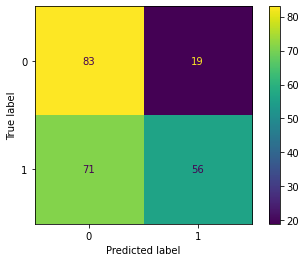

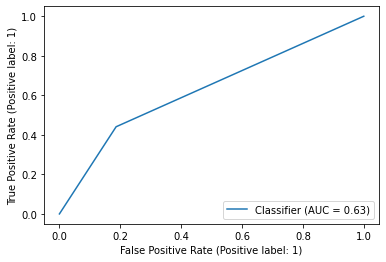

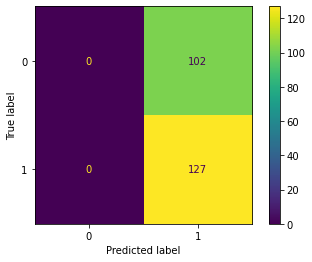

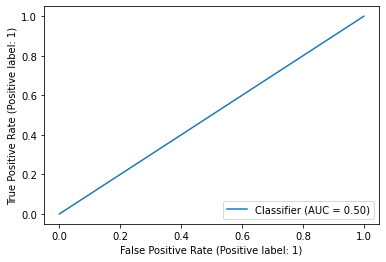

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
classification(GaussianNB, X_train, X_test, y_train, y_test)
classification(MultinomialNB, X_train, X_test, y_train, y_test)

#### Gradient Boosting Classifier

GradientBoostingClassifier - Params: {}
F1 Score: 0.8853754940711462
ACC: 0.8733624454148472


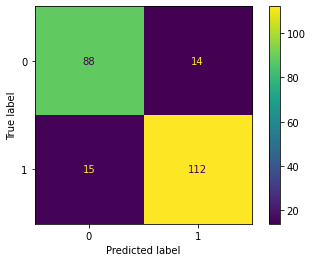

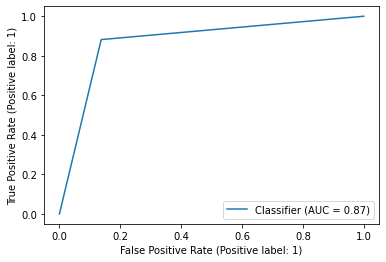

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
classification(GradientBoostingClassifier, X_train, X_test, y_train, y_test)

#### AdaBoostClassifier

AdaBoostClassifier - Params: {}
F1 Score: 0.8346456692913384
ACC: 0.8165938864628821


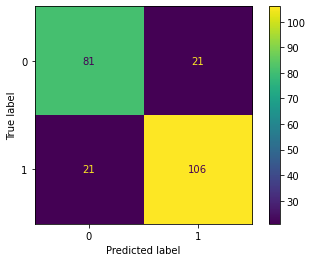

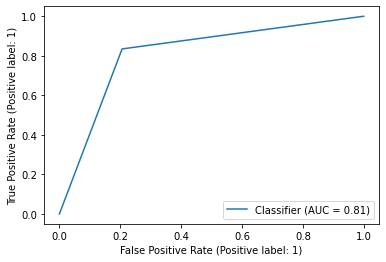

In [28]:
from sklearn.ensemble import AdaBoostClassifier
classification(AdaBoostClassifier, X_train, X_test, y_train, y_test)

#### LGBMClassifier

LGBMClassifier - Params: {}
F1 Score: 0.9193548387096775
ACC: 0.9126637554585153


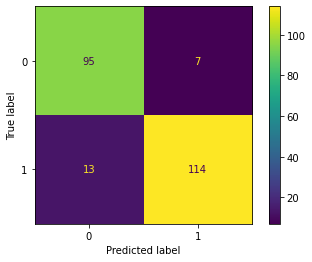

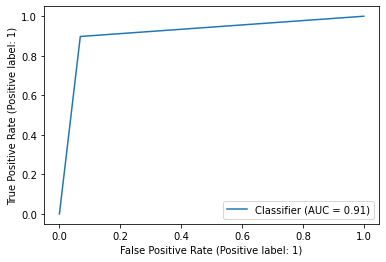

In [29]:
from lightgbm import LGBMClassifier
classification(LGBMClassifier, X_train, X_test, y_train, y_test)

## GRID SEARCH

In [90]:
def grid_search(estimator, X_train, y_train, args):
    clf = GridSearchCV(estimator(), args)
    clf.fit(X_train, y_train)
    print(" Results from Grid Search " )
    print("\n The best estimator across ALL searched params:\n",clf.best_estimator_)
    print("\n The best score across ALL searched params:\n",clf.best_score_)
    print("\n The best parameters across ALL searched params:\n",clf.best_params_)
    return clf.best_params_

#### SVC

 Results from Grid Search 

 The best estimator across ALL searched params:
 SVC(C=10)

 The best score across ALL searched params:
 0.9189875698072418

 The best parameters across ALL searched params:
 {'C': 10, 'kernel': 'rbf'}
SVC - Params: {'C': 10, 'kernel': 'rbf'}
F1 Score: 0.9119999999999999
ACC: 0.9039301310043668


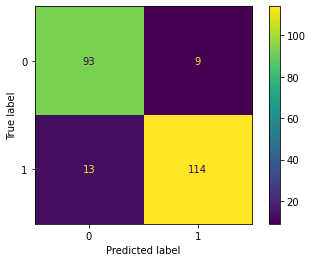

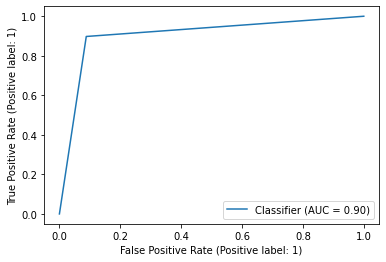

In [91]:
res = grid_search(SVC, X_train, y_train, {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'C': [x for x in range(1,11)]})
classification(SVC, X_train, X_test, y_train, y_test, **res)

### LDA

 Results from Grid Search 

 The best estimator across ALL searched params:
 LinearDiscriminantAnalysis(n_components=1)

 The best score across ALL searched params:
 0.7371524650213175

 The best parameters across ALL searched params:
 {'n_components': 1, 'solver': 'svd'}
LinearDiscriminantAnalysis - Params: {'n_components': 1, 'solver': 'svd'}
F1 Score: 0.7680608365019013
ACC: 0.7336244541484717


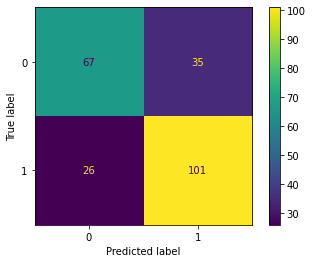

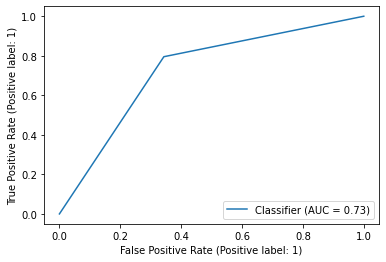

In [32]:
res = grid_search(LinearDiscriminantAnalysis, X_train, y_train, solver=('svd', 'lsqr', 'eigen'), n_components=[1])
classification(LinearDiscriminantAnalysis, X_train, X_test, y_train, y_test, **res)

### LGBMClassifier

 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMClassifier(boosting_type='dart', learning_rate=1)

 The best score across ALL searched params:
 0.895970695970696

 The best parameters across ALL searched params:
 {'boosting_type': 'dart', 'learning_rate': 1}
LGBMClassifier - Params: {'boosting_type': 'dart', 'learning_rate': 1}
F1 Score: 0.904
ACC: 0.8951965065502183


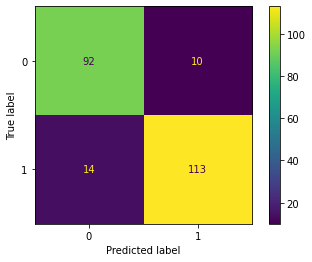

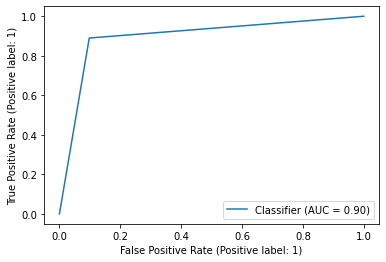

In [33]:
res = grid_search(LGBMClassifier, X_train, y_train, boosting_type =('gbdt', 'dart', 'goss'), learning_rate=[0.1, 0.25, 0.5, 1])
classification(LGBMClassifier, X_train, X_test, y_train, y_test, **res)

### NaiveBayes

 Results from Grid Search 

 The best estimator across ALL searched params:
 MultinomialNB(alpha=0.1)

 The best score across ALL searched params:
 0.546550171140335

 The best parameters across ALL searched params:
 {'alpha': 0.1}
MultinomialNB - Params: {}
F1 Score: 0.7134831460674157
ACC: 0.5545851528384279


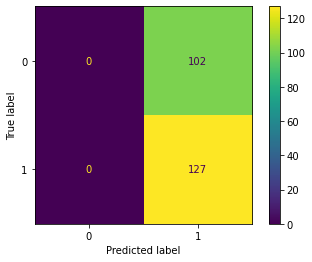

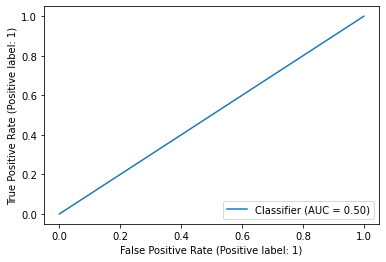

In [34]:
res = grid_search(MultinomialNB, X_train, y_train, alpha=[0.1, 0.5, 1, 2, 5, 10])
classification(MultinomialNB, X_train, X_test, y_train, y_test)

### KNN

 Results from Grid Search 

 The best estimator across ALL searched params:
 KNeighborsClassifier(n_neighbors=3)

 The best score across ALL searched params:
 0.9091094697652075

 The best parameters across ALL searched params:
 {'algorithm': 'auto', 'n_neighbors': 3, 'p': 2}
KNeighborsClassifier - Params: {}
F1 Score: 0.9019607843137255
ACC: 0.8908296943231441


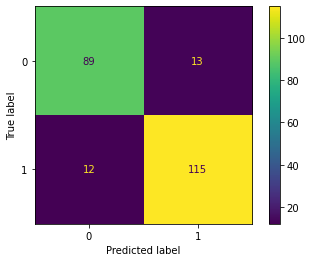

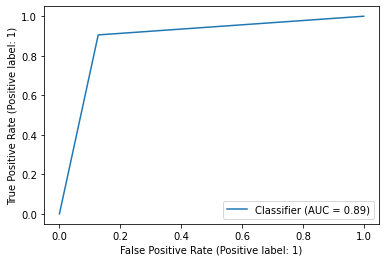

In [35]:
res = grid_search(
    KNeighborsClassifier,
    X_train,
    y_train,
    algorithm = ('auto', 'ball_tree', 'kd_tree', 'brute'),
    n_neighbors=[i for i in range(2,8)],
    p=[i for i in range(1,10)]
)
classification(KNeighborsClassifier, X_train, X_test, y_train, y_test)

## Main program to process

Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped
KNeighborsClassifier - Params: {}
F1 Score: 0.9142857142857144
ACC: 0.8951965065502183


(0.8951965065502183, 0.9142857142857144)

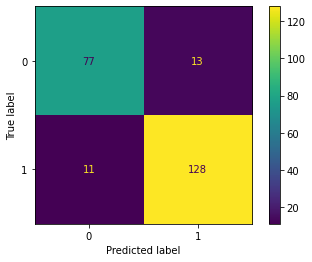

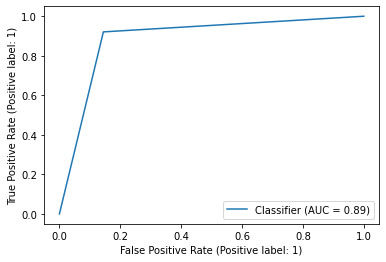

In [128]:
def process(
        preprocessing_method, extraction_method, selection_method, estimator,
        preprocessing_parameters = {}, selection_parameters = {}, classification_parameters = {},
        is_grid_search = False, grid_search_params = {},
    ):

    if preprocessing_method != None:
        X, y = transform(preprocessing(preprocessing_method, preprocessing_parameters))
    else:
        X, y = transform(load_edf())

    if extraction_method != None:
        extraction_X = extraction(extraction_method, X)
    else:
        extraction_X = extraction('variance', X)
    
    if selection_method != None:
        selected_X = selection(selection_method, extraction_X, y, selection_parameters)
    else:
        selected_X = extraction_X
    
    X_train, X_test, y_train, y_test = train_test_split(selected_X, y, test_size=0.2, shuffle=True)

    if is_grid_search:
        classification_parameters = grid_search(estimator, X_train, y_train, grid_search_params)

    acc, f1 = classification(estimator, X_train, X_test, y_train, y_test, **classification_parameters)

    return (acc, f1)

Examples:

Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped
KNeighborsClassifier - Params: {}
F1 Score: 0.942084942084942
ACC: 0.9344978165938864
Not setting metadata
1142 matching events found
No baseline correction applied
0 bad epochs dropped
KNeighborsClassifier - Params: {'algorithm': 'brute'}
F1 Score: 0.9538461538461539
ACC: 0.9475982532751092


,Preprocessing,Preprocessing parameters,Extraction,Extraction parameters,Selection,Classification,Classification parameters,Accuracy score,F1 score
0,None,None,Variable,None,None,KNeighborsClassifier,None,0.934498,0.942085
1,filter,"{'order': 6, 'f_pass': 50, 'f_stop': None, 'fi...",Variable,None,None,KNeighborsClassifier,{'algorithm': 'brute'},0.947598,0.953846


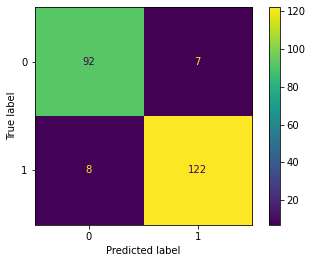

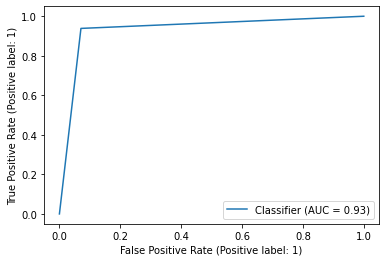

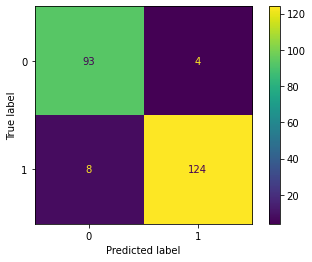

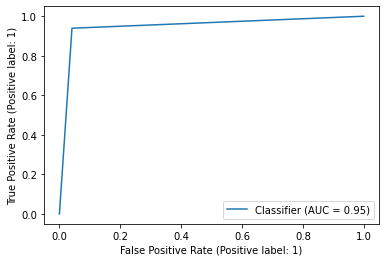

In [137]:
# process('filter', 'variance', 't_stats', KNeighborsClassifier, {'order': 6, 'f_pass': 50, 'f_stop': None, 'filter_type': 'low'}, classification_parameters = {'algorithm': 'brute'})
# process('filter',
#         'variance',
#         't_stats',
#         KNeighborsClassifier,
#         {'order': 6, 'f_pass': 50, 'f_stop': None, 'filter_type': 'low'},
#         classification_parameters = {'algorithm': 'brute'},
#         is_grid_search = True,
#         grid_search_params = {'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'n_neighbors': [i for i in range(2,8)], 'p': [i for i in range(1,10)]})
import pandas as pd

res_arr = []
acc, f1 = process(None, None, None, KNeighborsClassifier, classification_parameters = {'to_file': True})

res_arr.append({
    'Preprocessing': None,
    'Preprocessing parameters': None,
    'Extraction': 'Variable',
    'Extraction parameters': None,
    'Selection': None,
    'Classification': 'KNeighborsClassifier',
    'Classification parameters': None,
    'Accuracy score': acc,
    'F1 score': f1
})

acc, f1 = process('filter', 'variance', 't_stats', KNeighborsClassifier, {'order': 6, 'f_pass': 50, 'f_stop': None, 'filter_type': 'low'}, classification_parameters = {'algorithm': 'brute'})

res_arr.append({
    'Preprocessing': 'Filter',
    'Preprocessing parameters': str({'order': 6, 'f_pass': 50, 'f_stop': None, 'filter_type': 'low'}),
    'Extraction': 'Variable',
    'Extraction parameters': None,
    'Selection': None,
    'Classification': 'KNeighborsClassifier',
    'Classification parameters': str({'algorithm': 'brute'}),
    'Accuracy score': acc,
    'F1 score': f1
})

pd.DataFrame.from_records(res_arr)

